# Подсчет замаскированных и незамаскированных ругательств, исправление замаскированных

In [1]:
import gc
import re

import pandas as pd
import spacy
from pandarallel import pandarallel
from tqdm import tqdm

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
class SwearWordsCounter:
    def __init__(self):
        self.swear_words_count = 0
        self.mask_count = 0
        
    def update(self, swear_word, mask):
        self.swear_words_count += swear_word
        self.mask_count += mask

Для нахождения замаскированных ругательств будет использоваться словарь с регулярными выражениями для самых популярных масок слов и их базовые формы. Регулярными выражениями будем находить замаскированные (и отличные от базовой формв незамаскированные) ругательства и приводить их к базовой форме, базовые формы также будут использоваться для нахождения незамаскированных ругательств.

In [3]:
class SwearWordsProcessor:
    def __init__(self):
        self.mask_patterns = {
            re.compile(r'[f4$][u*µùúûü][c\(k<][k%]+', re.IGNORECASE): 'fuck',
            re.compile(r'[5$][h#][i1!][t+7]+', re.IGNORECASE): 'shit',
            re.compile(r'a[s$]{2}h[o0]l[e3]', re.IGNORECASE): 'asshole',
            re.compile(r'[b8][i1!][7+][c\(][h4]+', re.IGNORECASE): 'bitch',
            re.compile(r'\b[a@4][s$5]{2,}\b', re.IGNORECASE): 'ass',
            re.compile(r'\bp[1!i]ss\b', re.IGNORECASE): 'piss',
            re.compile(r'\b[d][a@4][m][nñ]+\b', re.IGNORECASE): 'damn',
            re.compile(r'\b[c\(][uµùúûü][nñ][t7+]+\b', re.IGNORECASE): 'cunt',
            re.compile(r'[p][0oöø][r][nñ]+', re.IGNORECASE): 'porn',
            re.compile(r'\b[w][h#][0oöø][r][e3€]+\b', re.IGNORECASE): 'whore',
            re.compile(r'\b[n][i1!][g6][g6][e3€][r®]+\b', re.IGNORECASE): 'nigger',
            re.compile(r'\b[f4$][a@4][g6][s$5]+\b', re.IGNORECASE): 'fags',
            re.compile(r'\b[s$5][l1!][uµùúûü][t7+]+\b', re.IGNORECASE): 'slut',
            re.compile(r'\b[d][1!][c\(][k%]+\b', re.IGNORECASE): 'dick',
            re.compile(r'\b[b8][0oöø][0oöø][b8]+\b', re.IGNORECASE): 'boob',
            re.compile(r'\b[c\(][0oöø][c\(][k%]+\b', re.IGNORECASE): 'cock',
            re.compile(r'\bb[o0]ll[o0]cks\b', re.IGNORECASE): 'bollocks',
            re.compile(r'\b[p][uµùúûü][s$5][s$5][y¥]+\b', re.IGNORECASE): 'pussy',
            re.compile(r'\b[m][0oöø][f4$][0oöø]+\b', re.IGNORECASE): 'mofo',
            re.compile(r'\b[t7+][w][a@4][t7+]+\b', re.IGNORECASE): 'twat',
            re.compile(r'\b[b8][a@4][s$5][t7+][a@4][r®][d]+\b', re.IGNORECASE): 'bastard',
            re.compile(r'\b[m][0oöø][t7+][h#][e3€][r®][f4$][uµùúûü][c$$][k%][e3€][r®]+\b', re.IGNORECASE): 'motherfucker',
            re.compile(r'\bw[a@]nk[e3]r\b', re.IGNORECASE): 'wanker'
        }

        self.swear_words = set(self.mask_patterns.values())
        self.nlp = spacy.load("en_core_web_sm")
    
    def count_swears(self, text: str):
        swear_spans = []
        # Находим незамаскированные ругательства и сохраняем их позиции
        for base in self.swear_words:
            for match in re.finditer(rf'\b{re.escape(base)}\b', text, re.IGNORECASE):
                swear_spans.append(match.span())
        
        masked_cnt = 0
        # Затем ищем замаскированные, исключая зоны с найденными swear
        for pattern, base in self.mask_patterns.items():
            for match in pattern.finditer(text):
                start, end = match.span()
                
                # Проверяем, не является ли это точным swear
                is_swear = any(
                    s_start <= start < s_end or s_start < end <= s_end 
                    for s_start, s_end in swear_spans
                )
                
                # Проверяем частичное совпадение с базовой формой
                if not is_swear and base in text[start:end].lower():
                    swear_spans.append((start, end))
                elif not is_swear:
                    masked_cnt += 1

        swear_cnt = len(swear_spans)
        del swear_spans
        gc.collect()
        
        return swear_cnt, masked_cnt

    
    def process_text(self, text: str):
        # Лемматизация текста
        doc = self.nlp(text)
        processed_parts = []
        for token in doc:
            processed_parts.append(token.lemma_.lower())
            if token.whitespace_:
                processed_parts.append(' ')

        processed_text = ''.join(processed_parts)
        del processed_parts
        gc.collect()

        swear_cnt, masked_cnt = self.count_swears(processed_text)
        
        # Замена замаскированных ругательств
        for pattern, base in self.mask_patterns.items():
            processed_text = pattern.sub(base, processed_text)
        
        stats = {
            "masked": masked_cnt,
            "swear": swear_cnt
        }
        
        return processed_text, stats

In [ ]:
import gc

total_rows = pd.read_csv('/Users/lev_k/HSE/YP/modified_train.csv', index_col=0).shape[0]
gc.collect()

total_stats = SwearWordsCounter()
processor = SwearWordsProcessor()
reader = pd.read_csv('/Users/lev_k/HSE/YP/modified_train.csv', chunksize=100000)
with tqdm(total=total_rows, desc="Processing") as pbar:
    for i, chunk in enumerate(reader):
        results = chunk.parallel_apply(
            lambda row: processor.process_text(row['comment_text']), 
            axis=1,
            result_type='expand'
        )
        
        # Обновляем статистику
        chunk_stats = results[1].apply(pd.Series).sum()
        total_stats.update(chunk_stats['swear'], chunk_stats['masked'])
        
        # Сохраняем результаты
        chunk['processed_swear_words'] = results[0]
        chunk['masked'] = results[1].apply(lambda stats: stats['masked'])
        chunk['swear'] = results[1].apply(lambda stats: stats['swear'])
        
        chunk.to_parquet(f'processed_chunk_{i}.parquet', index=False)

        pbar.update(len(chunk))

        del chunk, results
        gc.collect()

In [7]:
print(f"""
Статистика обработки:
- Незамаскированных ругательств: {total_stats.swear_words_count}
- Заменено масок ругательств: {total_stats.mask_count}
""")


Статистика обработки:
- Незамаскированных ругательств: 16581
- Заменено масок ругательств: 719



In [8]:
import glob

processed_df = pd.concat(
    [pd.read_parquet(f, engine='pyarrow') for f in glob.glob('processed_chunk_*.parquet')],
    ignore_index=False
)
processed_df.set_index('id', inplace=True)

In [46]:
processed_df['processed_swear_words'].fillna('', inplace=True)

In [47]:
processed_df.to_csv('processed_swear_words_train.csv')

**Распределение ругательств**

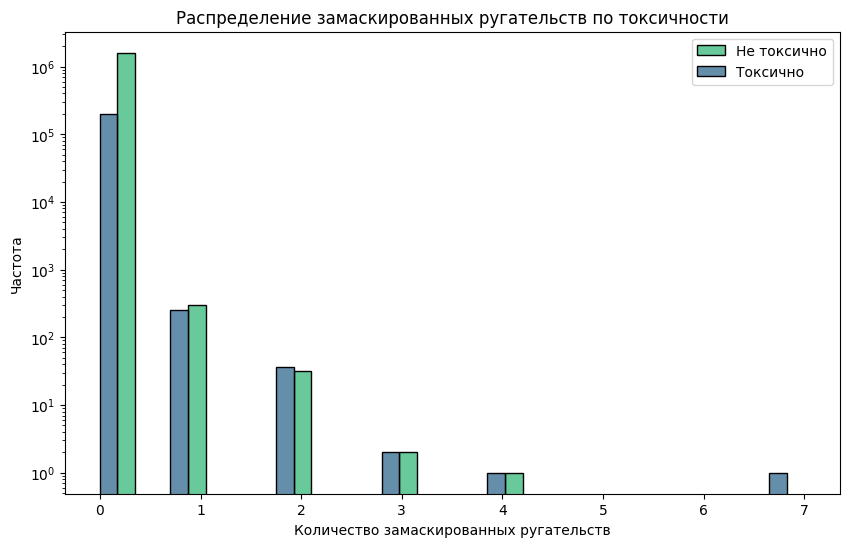

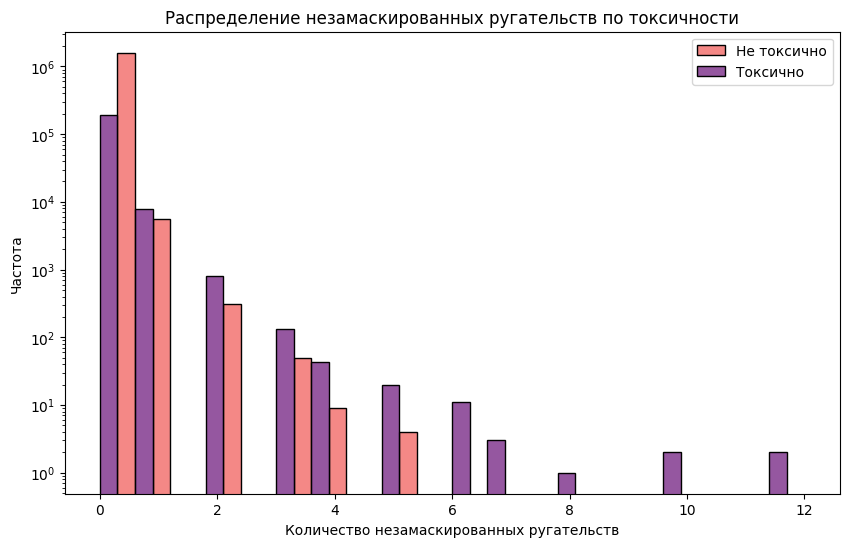

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(data=processed_df, x='masked', hue='toxicity_b', hue_order=[1, 0], kde=False, bins=20, palette="viridis", multiple="dodge")
plt.title('Распределение замаскированных ругательств по токсичности')
plt.xlabel('Количество замаскированных ругательств')
plt.ylabel('Частота')
plt.legend(labels=['Не токсично', 'Токсично'])
plt.yscale('log')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=processed_df, x='swear', hue='toxicity_b', hue_order=[1, 0], kde=False, bins=20, palette="magma", multiple="dodge")
plt.title('Распределение незамаскированных ругательств по токсичности')
plt.xlabel('Количество незамаскированных ругательств')
plt.ylabel('Частота')
plt.legend(labels=['Не токсично', 'Токсично'])
plt.yscale('log')
plt.show()

**Тест на равенство средних замаскированных и незамаскированных ругательств в токсичных и нетоксичных коментариях**

In [39]:
from scipy.stats import ttest_ind

masked_group_0 = processed_df[processed_df['toxicity_b'] == 0]['masked']
masked_group_1 = processed_df[processed_df['toxicity_b'] == 1]['masked']

swear_group_0 = processed_df[processed_df['toxicity_b'] == 0]['swear']
swear_group_1 = processed_df[processed_df['toxicity_b'] == 1]['swear']

masked_ttest = ttest_ind(masked_group_0, masked_group_1, equal_var=False)

swear_ttest = ttest_ind(swear_group_0, swear_group_1, equal_var=False)

print("T-тест для 'masked':", masked_ttest)
print("T-тест для 'swear':", swear_ttest)


T-тест для 'masked': TtestResult(statistic=-13.500864960929658, pvalue=1.6093809914173859e-41, df=207226.21091570923)
T-тест для 'swear': TtestResult(statistic=-78.85553906167331, pvalue=0.0, df=204545.48662591202)


**Тест на равенство средних замаскированных и незамаскированных ругательств только в токсичных коментариях**

In [ ]:
masked_group = processed_df[processed_df['toxicity_b'] == 1]['masked']
swear_group = processed_df[processed_df['toxicity_b'] == 1]['swear']

ttest_ind(masked_group, swear_group, equal_var=False)

TtestResult(statistic=-81.69249668106171, pvalue=0.0, df=215026.34766177257)

По результатам статистических тестов на равенство средних видно, что среднии значения для ругательств, как замаскрированных, так и незамаскированных, различаются, в токсичных комментариях их больше, особенно незамаскированных. В токсичных комментариях количество замаскированных ругательств сильно меньше, чем незамаскированных, в таком случае замаскированные ругательства лучше приводить к явному виду, т.к. они представляют важности для модели и могут наоборот запутать ее.